This is an example of a jupyter notebook, running using the `pixi` environment we created to manage our dependencies. Note that you may need to change your python interpreter (top right corner) to:
`.pixi/envs/default/bin/python`

In [1]:
import os
import glob
import re
import pandas as pd
import numpy as np
import random
import torch
import sklearn

#set up plotting
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=[15,5] #for large visuals
%config InlineBackend.figure_format = 'retina'

from sklearn.metrics import roc_auc_score
import bioacoustics_model_zoo as bmz
from opensoundscape.ml.shallow_classifier import quick_fit 

2025-03-27 22:01:18.720720: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-27 22:01:18.758907: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-27 22:01:18.758956: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-27 22:01:18.759003: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-27 22:01:18.767263: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: A

Pre-processing

In [ ]:
import requests
import zipfile
import os

url = "https://storage.googleapis.com/dse-staff-public/data.zip"
dest_path = "."

# Create destination directory if it doesn't exist
os.makedirs(dest_path, exist_ok=True)

# Download the ZIP file
response = requests.get(url, stream=True)
with open(os.path.join(dest_path, "data.zip"), 'wb') as f:
    for chunk in response.iter_content(chunk_size=1024): 
        if chunk: 
            f.write(chunk)

# Unzip the file
with zipfile.ZipFile(os.path.join(dest_path, "data.zip"), 'r') as zip_ref:
    zip_ref.extractall(dest_path)

In [2]:
datapath = "data/audio" # should use relative paths.
species = "bullfrog"
datatype = "data"

files = glob.glob(os.path.join(datapath, species, datatype, "**/*.wav"), recursive=True)
labels = pd.DataFrame({"file": files, "present": ["pos" in f.lower() for f in files]})

# Do this step ONLY to convert to 5 second dataset to run perch!!!!
labels['file'] = labels['file'].apply(lambda x: re.sub(r'data', 'data_5s', x, count=2).replace('data_5s', 'data', 1)) 

labels['file'] = labels['file'].astype(str)
labels.set_index("file", inplace=True)

pd.set_option('display.max_colwidth', 100)
print(labels.head())

                                                                present
file                                                                   
data/audio/bullfrog/data_5s/neg/bullfrog-neg-t-11113588_12.wav    False
data/audio/bullfrog/data_5s/neg/bullfrog-neg-t-11113588_5.wav     False
data/audio/bullfrog/data_5s/neg/bullfrog-neg-t-11113588_15.wav    False
data/audio/bullfrog/data_5s/neg/bullfrog-neg-t-11113588_4.wav     False
data/audio/bullfrog/data_5s/neg/bullfrog-neg-t-11113588_14.wav    False


In [3]:
labels_train, labels_val = sklearn.model_selection.train_test_split(labels[['present']])

Run Models

In [4]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [5]:
model = torch.hub.load('kitzeslab/bioacoustics-model-zoo', "Perch", trust_repo=True)

Using cache found in /home/jovyan/.cache/torch/hub/kitzeslab_bioacoustics-model-zoo_main
/home/jovyan/non-avian-ml-toy/.pixi/envs/default/lib/python3.10/site-packages/tensorflow_hub/__init__.py:61: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import parse_version
/home/jovyan/non-avian-ml-toy/.pixi/envs/default/lib/python3.10/site-packages/opensoundscape/ml/cnn.py:599: UserWarning: 
                    This architecture is not listed in opensoundscape.ml.cnn_architectures.ARCH_DICT.
                    It will not be available for loading after saving the model with .save() (unless using pickle=True). 
                    To make it re-loadable, define a function that generates the architecture from arguments: (n_classes, n_channels) 
                    then use opensoundscape.ml.cnn_architectures.register_architecture() to register the generating function.

                    The function 

In [6]:
emb_train = model.embed(labels_train, return_dfs=False, batch_size=128, num_workers=0)
emb_val = model.embed(labels_val, return_dfs=False, batch_size=128, num_workers=0)

model.change_classes(['present'])

/home/jovyan/non-avian-ml-toy/.pixi/envs/default/lib/python3.10/site-packages/opensoundscape/utils.py:349: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  clips[label_df.columns] = label_df.loc[f]
/home/jovyan/non-avian-ml-toy/.pixi/envs/default/lib/python3.10/site-packages/opensoundscape/utils.py:349: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  clips[label_df.columns] = label_df.loc[f]
/home/jovyan/non-avian-ml-toy/.pixi/envs/default/lib/python3.10/site-packages/opensoundscape/utils.py:349: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be tr

  0%|          | 0/1 [00:00<?, ?it/s]

2025-03-27 22:01:37.651743: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x6473d7eed2f0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-03-27 22:01:37.651785: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2025-03-27 22:01:38.080276: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-03-27 22:01:38.086854: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator jax2tf_infer_fn_/assert_equal_1/Assert/AssertGuard/Assert
2025-03-27 22:01:40.048124: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-03-27 22:01:40.058138: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
/home/j

  0%|          | 0/1 [00:00<?, ?it/s]

2025-03-27 22:01:47.990733: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator jax2tf_infer_fn_/assert_equal_1/Assert/AssertGuard/Assert


In the prior step is where the kernel crashes while embedding, apparently could be caused by a package installation issue with tensorflow or numpy (https://github.com/microsoft/vscode-jupyter/wiki/Kernel-crashes) 

Error: "The Kernel crashed while executing code in the current cell or a previous cell. Please review the code in the cell(s) to identify a possible cause of the failure."

In [7]:
quick_fit(model.network, emb_train, labels_train.values, emb_val, labels_val.values, steps=1000)

Epoch 100/1000, Loss: 0.19513235986232758, Val Loss: 0.30550941824913025
val AU ROC: 1.000
val MAP: 1.000
Epoch 200/1000, Loss: 0.09275074303150177, Val Loss: 0.1941622793674469
val AU ROC: 1.000
val MAP: 1.000
Epoch 300/1000, Loss: 0.054734814912080765, Val Loss: 0.14607861638069153
val AU ROC: 1.000
val MAP: 1.000
Epoch 400/1000, Loss: 0.036488428711891174, Val Loss: 0.12003502994775772
val AU ROC: 1.000
val MAP: 1.000
Epoch 500/1000, Loss: 0.026270871981978416, Val Loss: 0.10381510108709335
val AU ROC: 1.000
val MAP: 1.000
Epoch 600/1000, Loss: 0.0199284628033638, Val Loss: 0.09272949397563934
val AU ROC: 1.000
val MAP: 1.000
Epoch 700/1000, Loss: 0.015694553032517433, Val Loss: 0.08464182913303375
val AU ROC: 1.000
val MAP: 1.000
Epoch 800/1000, Loss: 0.012712191790342331, Val Loss: 0.07845142483711243
val AU ROC: 1.000
val MAP: 1.000
Epoch 900/1000, Loss: 0.010523129254579544, Val Loss: 0.07353681325912476
val AU ROC: 1.000
val MAP: 1.000
Epoch 1000/1000, Loss: 0.00886331498622894

In [8]:
predictions = model.network(torch.tensor(emb_val).float()).detach().numpy()
score = roc_auc_score(labels_val.values, predictions, average=None)

print(score)

1.0


/home/jovyan/non-avian-ml-toy/.pixi/envs/default/lib/python3.10/site-packages/matplotlib_inline/config.py:68: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


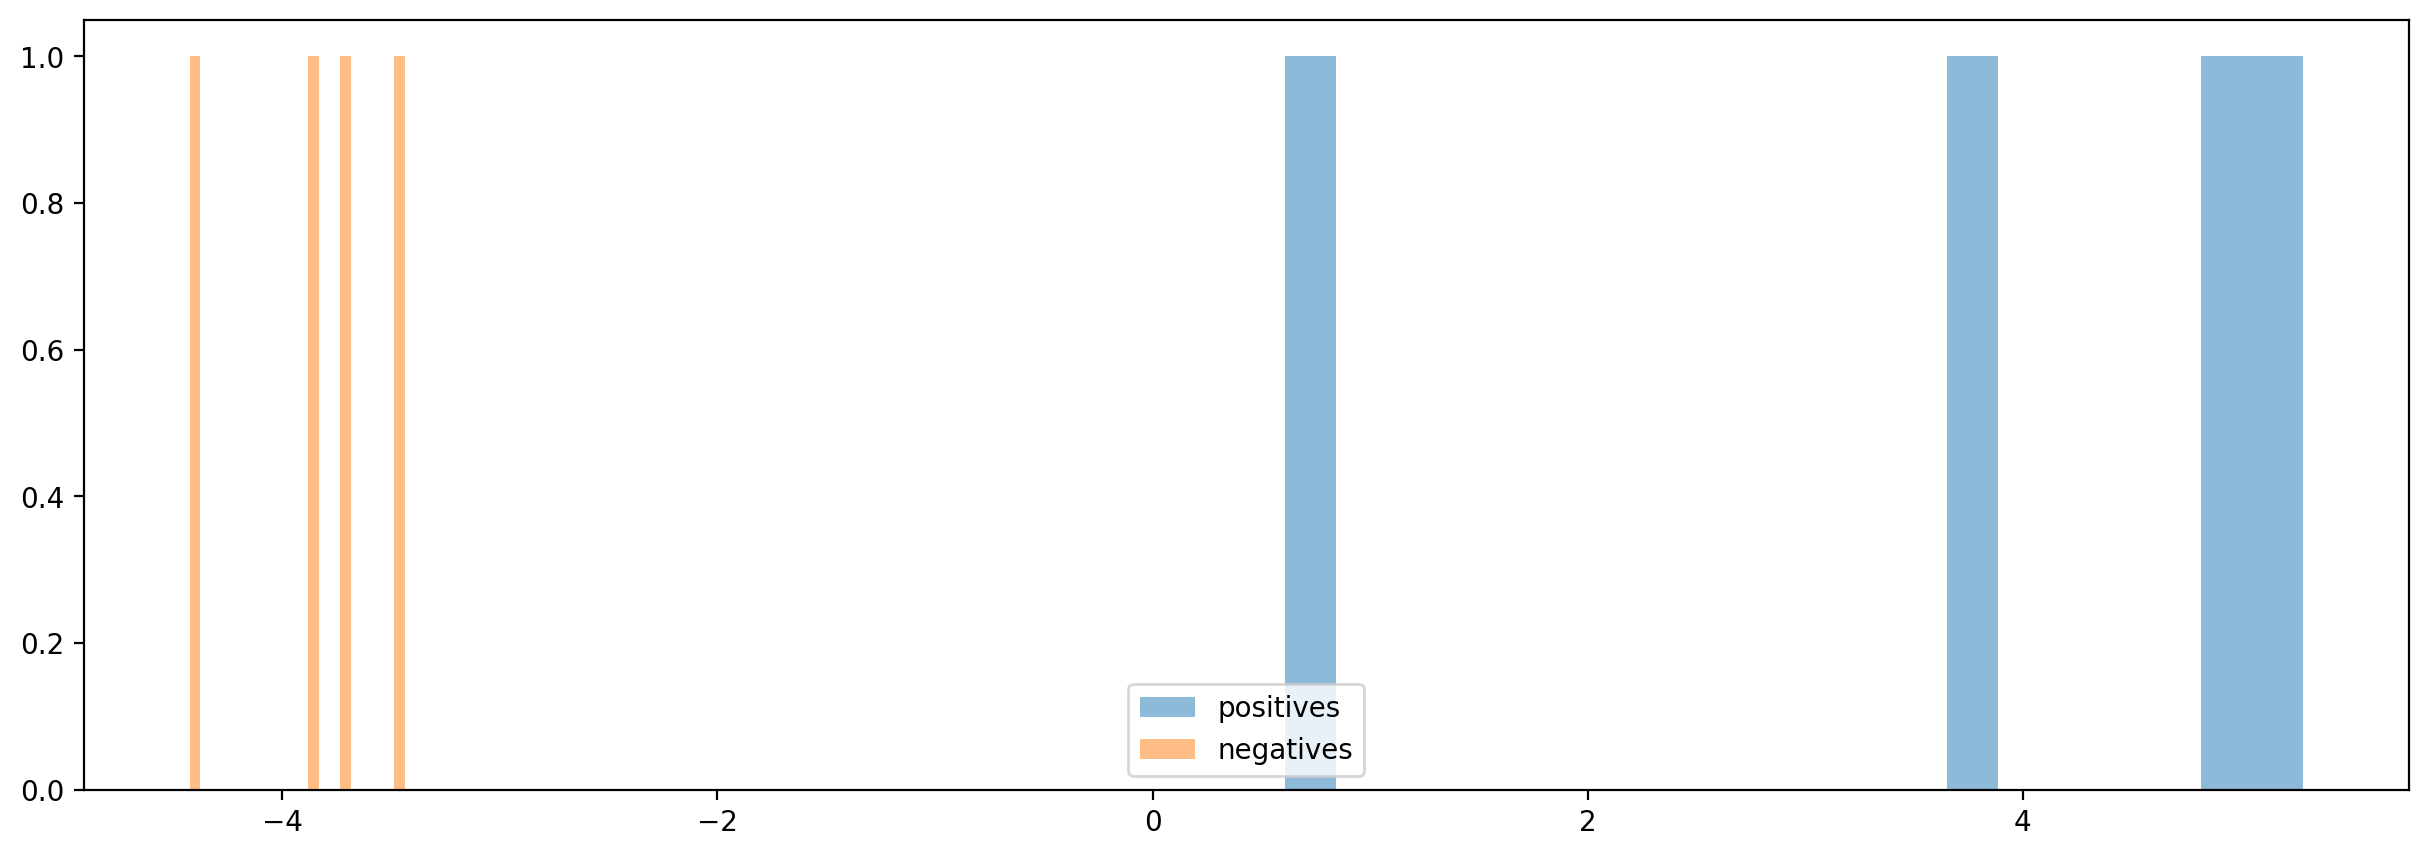

In [9]:
plt.hist(predictions[labels_val==True],bins=20,alpha=0.5,label='positives')
plt.hist(predictions[labels_val==False],bins=20,alpha=0.5,label='negatives')
plt.legend()